In [ ]:
# Install Tesseract OCR engine
!apt-get install -y tesseract-ocr

# Install pytesseract and OpenCV
!pip install pytesseract opencv-python

!pip install tflite-runtime


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.9 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
from tflite_runtime.interpreter import Interpreter

In [ ]:
# prompt: unzip file

!unzip /content/custom_model_lite.zip


Archive:  /content/custom_model_lite.zip
   creating: content/custom_model_lite/
   creating: content/custom_model_lite/saved_model/
  inflating: content/custom_model_lite/saved_model/saved_model.pb  
   creating: content/custom_model_lite/saved_model/variables/
  inflating: content/custom_model_lite/saved_model/variables/variables.data-00000-of-00001  
  inflating: content/custom_model_lite/saved_model/variables/variables.index  
   creating: content/custom_model_lite/saved_model/assets/
  inflating: content/custom_model_lite/detect.tflite  
 extracting: content/custom_model_lite/labels.txt  


In [ ]:


def tflite_detect_image(modelpath, image_path, lblpath, min_conf=0.5, savepath='/content/results', txt_only=False):
    # Load the label map into memory
    with open(lblpath, 'r') as f:
        labels = [line.strip() for line in f.readlines()]
        for idx, label in enumerate(labels):
            print(f"Label index {idx}: {label}")

    # Load the TensorFlow Lite model into memory
    interpreter = Interpreter(model_path=modelpath)
    interpreter.allocate_tensors()

    # Get model details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]
    float_input = (input_details[0]['dtype'] == np.float32)

    input_mean = 127.5
    input_std = 127.5

    # Load image and resize to expected shape [1xHxWx3]
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imH, imW, _ = image.shape
    image_resized = cv2.resize(image_rgb, (width, height))
    input_data = np.expand_dims(image_resized, axis=0)

    # Normalize pixel values if using a floating-point model (non-quantized model)
    if float_input:
        input_data = (np.float32(input_data) - input_mean) / input_std

    # Perform the actual detection by running the model with the image as input
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    # Retrieve detection results
    boxes = interpreter.get_tensor(output_details[1]['index'])[0]  # Bounding box coordinates
    classes = interpreter.get_tensor(output_details[3]['index'])[0]  # Class index
    scores = interpreter.get_tensor(output_details[0]['index'])[0]  # Confidence scores

    detections = []
    rois = []  # List to store ROIs

    # Loop over all detections and filter based on the confidence threshold
    for i in range(len(scores)):
        if ((scores[i] > min_conf) and (scores[i] <= 1.0)):
            # Get bounding box coordinates
            ymin = int(max(1, (boxes[i][0] * imH)))
            xmin = int(max(1, (boxes[i][1] * imW)))
            ymax = int(min(imH, (boxes[i][2] * imH)))
            xmax = int(min(imW, (boxes[i][3] * imW)))

            # Get the label for the detected class
            object_name = labels[int(classes[i])]
            detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])

            # Extract ROI (Region of Interest)
            roi = image[ymin:ymax, xmin:xmax]
            rois.append((object_name, roi))  # Save ROI with its label

    if not txt_only:
        # Draw rectangles and labels on the image
        for detection in detections:
            cv2.rectangle(image, (detection[2], detection[3]), (detection[4], detection[5]), (10, 255, 0), 2)
            label = '%s: %.2f%%' % (detection[0], detection[1] * 100)
            cv2.putText(image, label, (detection[2], detection[3] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Show the image with detections
        plt.figure(figsize=(12, 16))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    else:
        # Save detection results to a .txt file
        image_fn = os.path.basename(image_path)
        base_fn, ext = os.path.splitext(image_fn)
        txt_result_fn = base_fn + '.txt'
        txt_savepath = os.path.join(savepath, txt_result_fn)
        with open(txt_savepath, 'w') as f:
            for detection in detections:
                f.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

    return detections, rois  # Return detections and ROIs


Label index 0: table detection - v6 2023-01-17 11-32am


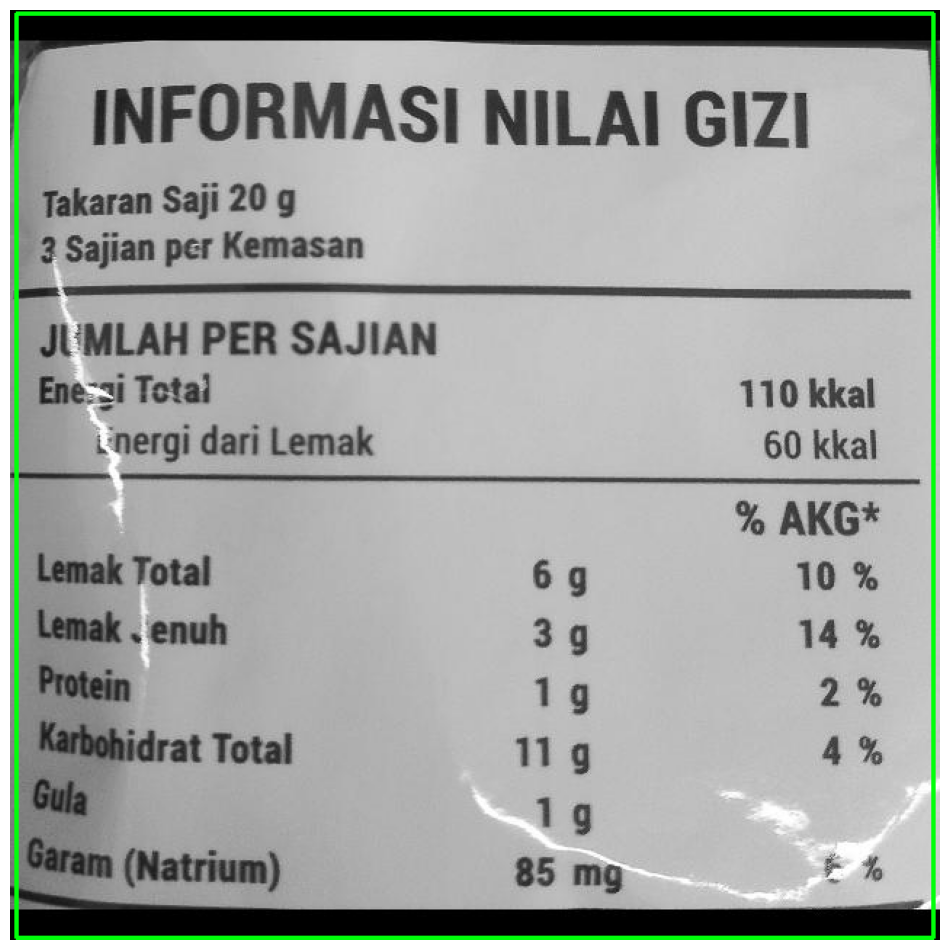

Detected ROIs:
ROI 1: x=4, y=2, width=631, height=636


In [ ]:
# Paths to the model, image, and labels
model_path = "/content/content/custom_model_lite/detect.tflite"
image_path = "/content/20241103_165353_jpg.rf.d062943d1ec15d01c7b2590466ce7410.jpg"
label_path = "/content/content/custom_model_lite/labels.txt"

# Perform object detection and get ROIs
detections, rois = tflite_detect_image(model_path, image_path, label_path, min_conf=0.5)

# Loop through the detections and print x, y, width, height
print("Detected ROIs:")
for idx, detection in enumerate(detections):
    _, _, xmin, ymin, xmax, ymax = detection
    width = xmax - xmin
    height = ymax - ymin
    print(f"ROI {idx + 1}: x={xmin}, y={ymin}, width={width}, height={height}")
    x = idx+1
    y = xmin
    w = width
    h = height

In [ ]:
import cv2
import pytesseract

def ocr_on_roi(image_path, x, y, width, height):
    """
    Extracts the Region of Interest (ROI) from the image and performs OCR on it.

    Args:
        image_path (str): Path to the image.
        x (int): The x-coordinate of the top-left corner of the ROI.
        y (int): The y-coordinate of the top-left corner of the ROI.
        width (int): The width of the ROI.
        height (int): The height of the ROI.

    Returns:
        str: The OCR text result from the ROI.
    """
    # Load the image
    image = cv2.imread(image_path)

    # Extract the Region of Interest (ROI)
    roi = image[y:y+height, x:x+width]

    # Convert the ROI to grayscale for better OCR results
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Perform OCR on the ROI
    ocr_result = pytesseract.image_to_string(gray_roi)

    return ocr_result


In [ ]:

# Perform OCR on the ROI
ocr_result = ocr_on_roi(image_path, x, y, w, h)

# Print the OCR result
print("OCR Result from ROI:")
print(ocr_result)

OCR Result from ROI:
} INFORMASI NILAI GIZI

Takaran Saji 20 g
3 Sajian per Kemasan

JUMLAH PER SAJIAN

 

Ene-3i Total 110 kkal

cnergi dari Lemak 60 kkal

% AKG*

Lemak Total 6g 10 %

Lemak . enuh 3g 14%

Protein 1g 2%

Karbohidrat Total 11g 4%
Gula lg

Garam (Natrium) 85 mg tt



In [ ]:
import re

def find_line_with_word(text, word):
    """
    Finds and returns the entire line containing the specified word.

    Parameters:
        text (str): The input text to search.
        word (str): The word to search for.

    Returns:
        list: A list of lines containing the word.
    """
    # Compile a regex pattern for the word with word boundaries
    pattern = re.compile(rf'\b{re.escape(word)}\b', re.IGNORECASE)

    # Split the text into lines
    lines = text.splitlines()

    # Find and return lines containing the word
    matched_lines = [line for line in lines if pattern.search(line)]
    return matched_lines

# Find and print lines containing the words in the list
words = ["gula", "protein", "karbohidrat", "energi"]  # Add more words as needed
for word in words:
    lines = find_line_with_word(ocr_result, word)
    print(f"\nLines containing '{word}':")
    for line in lines:
        print(line)


Lines containing 'gula':
Gula lg

Lines containing 'protein':
Protein 1g 2%

Lines containing 'karbohidrat':
Karbohidrat Total 11g 4%

Lines containing 'energi':
